In [1]:
from data_pipeline import *
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from clustering import *
import seaborn as sns
import scipy.stats as stats
from syntren import *
from gnw import *

In [2]:
root_gene = 'CRP'
minimum_evidence = 'weak'
max_depth = np.inf
r_expr, gene_symbols, sample_names = load_data(root_gene=root_gene,
                                     minimum_evidence=minimum_evidence,
                                     max_depth=max_depth)

# Split data into train and test sets
train_idxs, test_idxs = split_train_test(sample_names)
expr_train = r_expr[train_idxs, :]
expr_test = r_expr[test_idxs, :]
nb_train, nb_genes = expr_train.shape

# Find minimum and maximum expression values
r_min = np.min(expr_train)
r_max = np.max(expr_train)

# Find mean and std of each gene
r_mean = np.mean(expr_train, axis=0)
r_std = np.std(expr_train, axis=0)

### GAN data ###
synthetic_name = 'EColi_n{}_r{}_e{}_d{}'.format(len(gene_symbols), root_gene, minimum_evidence, max_depth)
s_expr, s_gs = load_synthetic(synthetic_name)
assert (np.array(gene_symbols) == np.array(s_gs)).all()

# Clip outliers
s_expr[s_expr < r_min] = r_min
s_expr[s_expr > r_max] = r_max

gan_expr = s_expr

### SynTReN data ###
s_expr, s_gene_symbols = syntren_results(minimum_evidence='Weak',
                                         nb_background=0)

# Align synthetic gene symbols
idxs = [s_gene_symbols.index(gene) for gene in gene_symbols]
s_expr = s_expr[:nb_train, idxs]
assert (np.array(s_gene_symbols)[idxs] == np.array(gene_symbols)).all()

# Adjust scale of SynTReN data
mean = np.mean(s_expr, axis=0)
std = np.std(s_expr, axis=0)
s_expr = (s_expr - mean)/std
s_expr = s_expr * r_std + r_mean

# Clip outliers
s_expr[s_expr < r_min] = r_min
s_expr[s_expr > r_max] = r_max

syn_expr = s_expr

### GNW data ###
s_expr, s_gene_symbols = gnw_results(minimum_evidence='Weak',
                                     break_loops=False)

# Align synthetic gene symbols
idxs = [s_gene_symbols.index(gene) for gene in gene_symbols]
s_expr = s_expr[:nb_train, idxs]
assert (np.array(s_gene_symbols)[idxs] == np.array(gene_symbols)).all()

# Adjust scale of GNW data
mean = np.mean(s_expr, axis=0)
std = np.std(s_expr, axis=0)
s_expr = (s_expr - mean)/std

s_expr = s_expr * r_std + r_mean

# Clip outliers
s_expr[s_expr < r_min] = r_min
s_expr[s_expr > r_max] = r_max

gnw_expr = s_expr

Found 4297 genes in datafile
Found 1208 genes in CRP regulatory network
4297 genes not in gene subset. Selecting 1076 genes ...


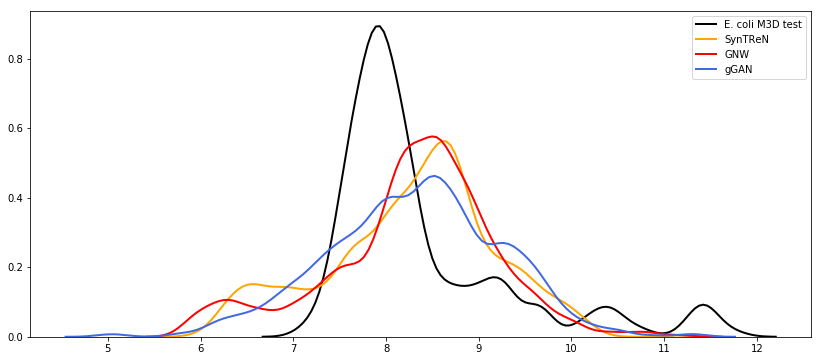

In [147]:
plt.figure(figsize=(14, 6))
idx = 27
plot_distribution(expr_test[:, idx], color='black', label='E. coli M3D test');
plot_distribution(syn_expr[:, idx], color='orange', label='SynTReN');
plot_distribution(gnw_expr[:, idx], color='red', label='GNW');
plot_distribution(gan_expr[:, idx], color='royalblue', label='gGAN');

# Intensity histograms

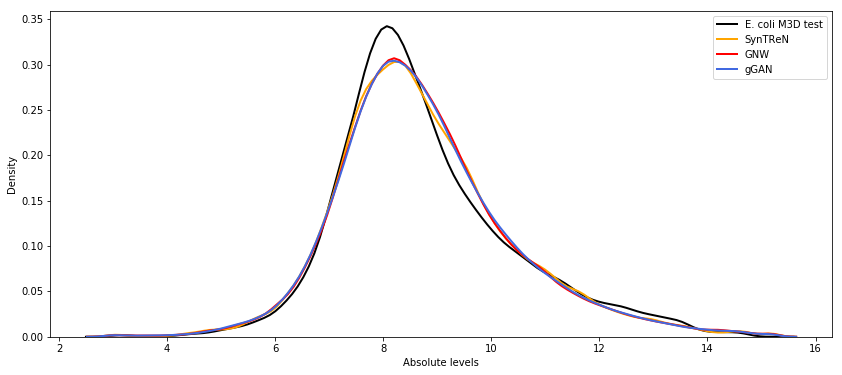

In [148]:
plt.figure(figsize=(14, 6))
# ax = plot_intensities(expr_train, dataset_name='E. coli M3D train', plot_quantiles=False)
ax = plot_intensities(expr_test, dataset_name='E. coli M3D test', color='black', plot_quantiles=False)
ax = plot_intensities(syn_expr, dataset_name='SynTReN', color='orange', plot_quantiles=False, ax=ax);
ax = plot_intensities(gnw_expr, dataset_name='GNW', color='red', plot_quantiles=False, ax=ax)
ax = plot_intensities(gan_expr, dataset_name='gGAN', color='royalblue', plot_quantiles=False, ax=ax);

# Gene ranges histograms

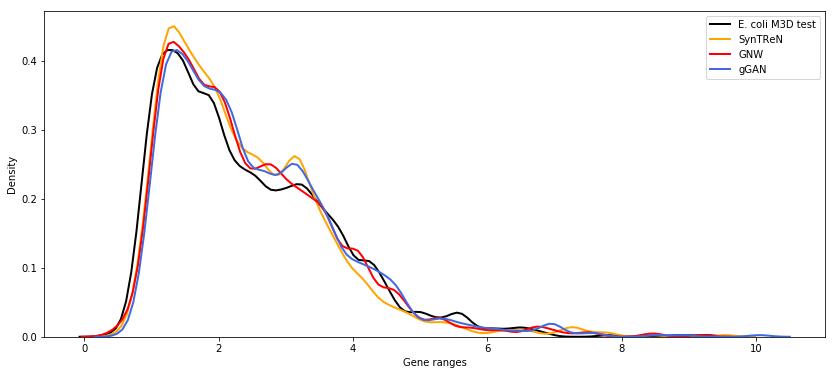

In [149]:
plt.figure(figsize=(14, 6))
# ax = plot_gene_ranges(expr_train, dataset_name='E. coli M3D train')
ax = plot_gene_ranges(expr_test, dataset_name='E. coli M3D test', color='black')
ax = plot_gene_ranges(syn_expr, dataset_name='SynTReN', color='orange', ax=ax)
ax = plot_gene_ranges(gnw_expr, dataset_name='GNW', color='red', ax=ax)
plot_gene_ranges(gan_expr, dataset_name='gGAN', color='royalblue', ax=ax);

# TF-TG histogram (using synthetic background distribution)

In [104]:
train_tf_tg_corr, train_tg_tg_corr = compute_tf_tg_corrs(expr_train, gene_symbols)
r_tf_tg_corr, r_tg_tg_corr = compute_tf_tg_corrs(expr_test, gene_symbols)
syn_tf_tg_corr, syn_tg_tg_corr = compute_tf_tg_corrs(syn_expr, gene_symbols)
gnw_tf_tg_corr, gnw_tg_tg_corr = compute_tf_tg_corrs(gnw_expr, gene_symbols)
gan_tf_tg_corr, gan_tg_tg_corr = compute_tf_tg_corrs(gan_expr, gene_symbols)
train_back_corr = correlations_list(expr_train, expr_train)
r_back_corr = correlations_list(expr_test, expr_test)
syn_back_corr = correlations_list(syn_expr, syn_expr)
gnw_back_corr = correlations_list(gnw_expr, gnw_expr)
gan_back_corr = correlations_list(gan_expr, gan_expr)

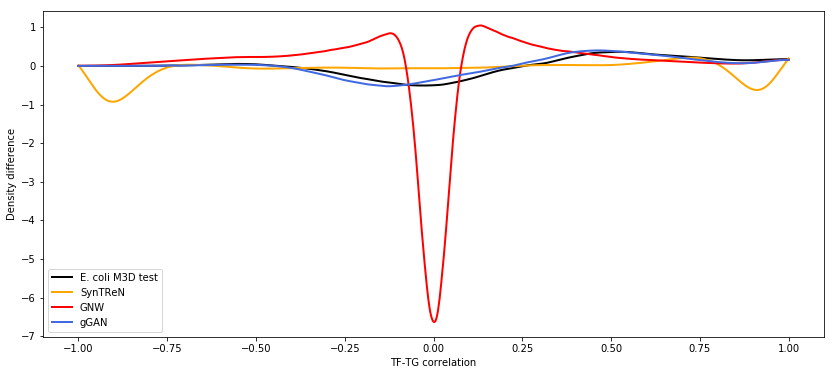

In [105]:
plt.figure(figsize=(14, 6))
ax = plot_difference_histogram(r_tf_tg_corr, r_back_corr, 'TF-TG correlation', dataset_name='E. coli M3D test', color='black')
ax = plot_difference_histogram(syn_tf_tg_corr, syn_back_corr, 'TF-TG correlation', dataset_name='SynTReN', color='orange', ax=ax); 
ax = plot_difference_histogram(gnw_tf_tg_corr, gnw_back_corr, 'TF-TG correlation', dataset_name='GNW', color='red', ax=ax); 
plot_difference_histogram(gan_tf_tg_corr, gan_back_corr, 'TF-TG correlation', dataset_name='gGAN', color='royalblue', ax=ax); 

# TG-TG histogram (using synthetic background distribution)

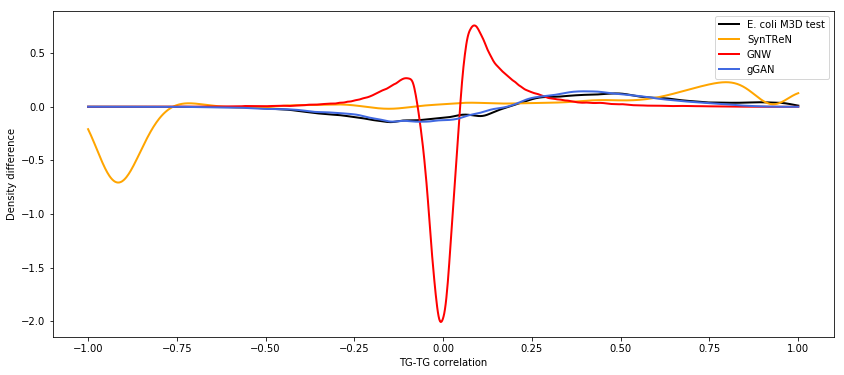

In [54]:
plt.figure(figsize=(14, 6))
# ax = plot_difference_histogram(train_tg_tg_corr, train_back_corr, 'TG-TG correlation', dataset_name='E. coli M3D train', color='green')
ax = plot_difference_histogram(r_tg_tg_corr, r_back_corr, 'TG-TG correlation', dataset_name='E. coli M3D test', color='black', ax=ax)
ax = plot_difference_histogram(syn_tg_tg_corr, syn_back_corr, 'TG-TG correlation', dataset_name='SynTReN', color='orange', ax=ax);
ax = plot_difference_histogram(gnw_tg_tg_corr, gnw_back_corr, 'TG-TG correlation', dataset_name='GNW', color='red', ax=ax);
ax = plot_difference_histogram(gan_tg_tg_corr, gan_back_corr, 'TG-TG correlation', dataset_name='gGAN', color='royalblue', ax=ax);

# Compare background distributions

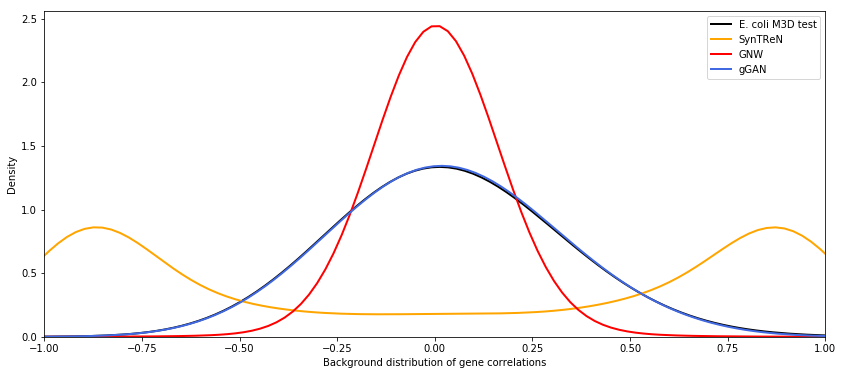

In [106]:
plt.figure(figsize=(14, 6))
# ax = plot_distribution(train_back_corr, label='E. coli M3D train')
ax = plot_distribution(r_back_corr, label='E. coli M3D test', color='black')
ax = plot_distribution(syn_back_corr, label='SynTReN', color='orange', ax=ax)
ax = plot_distribution(gnw_back_corr, label='GNW', color='red', ax=ax)
ax = plot_distribution(gan_back_corr, xlabel='Background distribution of gene correlations', ylabel='Density', label='gGAN', color='royalblue')
ax.set_xlim((-1, 1));

# TF activity histogram

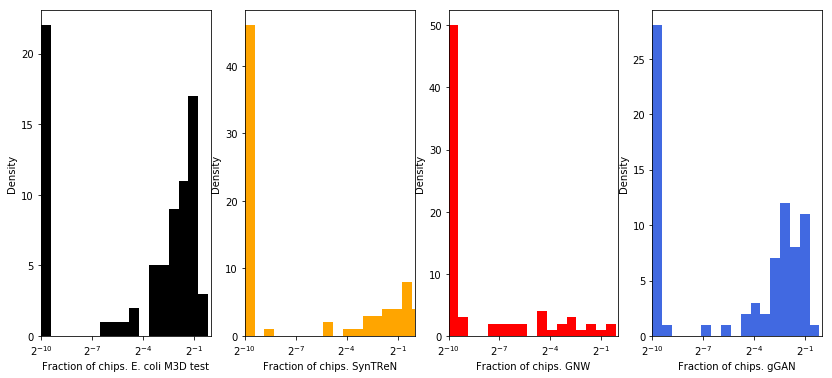

In [107]:
plt.figure(figsize=(14, 6))
plt.subplot(141)
plot_tf_activity_histogram(expr_test, gene_symbols, xlabel='Fraction of chips. E. coli M3D test', color='black')
plt.subplot(142)
plot_tf_activity_histogram(syn_expr, gene_symbols, xlabel='Fraction of chips. SynTReN', color='orange')
plt.subplot(143)
plot_tf_activity_histogram(gnw_expr, gene_symbols, xlabel='Fraction of chips. GNW', color='red')
plt.subplot(144)
plot_tf_activity_histogram(gan_expr, gene_symbols, xlabel='Fraction of chips. gGAN', color='royalblue');

# Quantitative analysis

In [3]:
r_tf_tg_corr, r_tg_tg_corr = compute_tf_tg_corrs(expr_test, gene_symbols, flat=False)

print('SynTReN')
gamma_dx_dz, gamma_dx_tx, gamma_dz_tz, gamma_tx_tz = gamma_coefficients(expr_test, syn_expr)
print('Gamma(D^X, D^Z): {}'.format(gamma_dx_dz))
print('Gamma(D^X, T^X): {}'.format(gamma_dx_tx))
print('Gamma(D^Z, T^Z): {}'.format(gamma_dz_tz))
print('Gamma(T^X, T^Z): {}'.format(gamma_tx_tz))

s_tf_tg_corr, s_tg_tg_corr = compute_tf_tg_corrs(syn_expr, gene_symbols, flat=False)
psi_dx_dz = psi_coefficient(r_tf_tg_corr, s_tf_tg_corr)
theta_dx_dz = theta_coefficient(r_tg_tg_corr, s_tg_tg_corr)
print('Psi(D^X, D^Z): {}'.format(psi_dx_dz))
print('Phi(D^X, D^Z): {}'.format(theta_dx_dz))


print('GNW')
gamma_dx_dz, gamma_dx_tx, gamma_dz_tz, gamma_tx_tz = gamma_coefficients(expr_test, gnw_expr)
print('Gamma(D^X, D^Z): {}'.format(gamma_dx_dz))
print('Gamma(D^X, T^X): {}'.format(gamma_dx_tx))
print('Gamma(D^Z, T^Z): {}'.format(gamma_dz_tz))
print('Gamma(T^X, T^Z): {}'.format(gamma_tx_tz))

s_tf_tg_corr, s_tg_tg_corr = compute_tf_tg_corrs(gnw_expr, gene_symbols, flat=False)
psi_dx_dz = psi_coefficient(r_tf_tg_corr, s_tf_tg_corr)
theta_dx_dz = theta_coefficient(r_tg_tg_corr, s_tg_tg_corr)
print('Psi(D^X, D^Z): {}'.format(psi_dx_dz))
print('Phi(D^X, D^Z): {}'.format(theta_dx_dz))


print('gGAN')
gamma_dx_dz, gamma_dx_tx, gamma_dz_tz, gamma_tx_tz = gamma_coefficients(expr_test, gan_expr)
print('Gamma(D^X, D^Z): {}'.format(gamma_dx_dz))
print('Gamma(D^X, T^X): {}'.format(gamma_dx_tx))
print('Gamma(D^Z, T^Z): {}'.format(gamma_dz_tz))
print('Gamma(T^X, T^Z): {}'.format(gamma_tx_tz))

s_tf_tg_corr, s_tg_tg_corr = compute_tf_tg_corrs(gan_expr, gene_symbols, flat=False)
psi_dx_dz = psi_coefficient(r_tf_tg_corr, s_tf_tg_corr)
theta_dx_dz = theta_coefficient(r_tg_tg_corr, s_tg_tg_corr)
print('Psi(D^X, D^Z): {}'.format(psi_dx_dz))
print('Phi(D^X, D^Z): {}'.format(theta_dx_dz))


print('Real')
gamma_dx_dz, gamma_dx_tx, gamma_dz_tz, gamma_tx_tz = gamma_coefficients(expr_test, expr_train)
print('Gamma(D^X, D^Z): {}'.format(gamma_dx_dz))
print('Gamma(D^X, T^X): {}'.format(gamma_dx_tx))
print('Gamma(D^Z, T^Z): {}'.format(gamma_dz_tz))
print('Gamma(T^X, T^Z): {}'.format(gamma_tx_tz))

s_tf_tg_corr, s_tg_tg_corr = compute_tf_tg_corrs(expr_train, gene_symbols, flat=False)
psi_dx_dz = psi_coefficient(r_tf_tg_corr, s_tf_tg_corr)
theta_dx_dz = theta_coefficient(r_tg_tg_corr, s_tg_tg_corr)
print('Psi(D^X, D^Z): {}'.format(psi_dx_dz))
print('Phi(D^X, D^Z): {}'.format(theta_dx_dz))

SynTReN
Gamma(D^X, D^Z): 0.02099262871004501
Gamma(D^X, T^X): 0.5456429177501786
Gamma(D^Z, T^Z): 0.9078867604695625
Gamma(T^X, T^Z): 0.020076682391265217
Psi(D^X, D^Z): 0.1637559279642501
Phi(D^X, D^Z): 0.21272888483389135
GNW
Gamma(D^X, D^Z): 0.05216421314994754
Gamma(D^X, T^X): 0.5456429177501786
Gamma(D^Z, T^Z): 0.30901209684330433
Gamma(T^X, T^Z): 0.036118853174759775
Psi(D^X, D^Z): 0.15600294961428599
Phi(D^X, D^Z): 0.1775158848849987
gGAN
Gamma(D^X, D^Z): 0.8206112751093215
Gamma(D^X, T^X): 0.5456429177501786
Gamma(D^Z, T^Z): 0.5005029147510579
Gamma(T^X, T^Z): 0.40207634202528725
Psi(D^X, D^Z): 0.8599364429281087
Phi(D^X, D^Z): 0.882998474725068
Real
Gamma(D^X, D^Z): 0.9109078771438015
Gamma(D^X, T^X): 0.5456429177501786
Gamma(D^Z, T^Z): 0.5308278489633552
Gamma(T^X, T^Z): 0.5197255060786521
Psi(D^X, D^Z): 0.9143066268198939
Phi(D^X, D^Z): 0.9467566219081305
